# Artificial Pancreas – v6.3 Realism Engine  
Cohort simulation with PK/PD + Hybrid Controller + Safety


This notebook contains the **v6.3 Artificial Pancreas realism engine**:

- PK/PD patient model
- Simple state observer
- Enhanced safety layer
- Hybrid (PID-style) insulin controller
- Realistic simulator with meals, noise, and variability
- Cohort runner and summary plots

All components are defined below in clean, modular cells.


In [1]:
# ========== REALISM v6.3 CELL ==========
import numpy as np, matplotlib.pyplot as plt, pandas as pd, random, warnings
from copy import deepcopy
warnings.filterwarnings("ignore")

# -------------------------
# PKPDPatient_v6_3: same as v6.2
# -------------------------


In [2]:
class PKPDPatient_v6_3:
    def __init__(self,
                 Gb=95.0,
                 p1=0.028, p2=0.03, p3=1.0e-5,
                 Vg=12.0, Vi=11.0,
                 ka1=0.011, ka2=0.0030, ke=0.035,
                 D_rate=1.0,
                 tau_X=105.0,
                 EGP0=1.5, k_egp=0.65):
        self.Gb = float(Gb)
        self.p1 = float(p1)
        self.p2 = float(p2)
        self.p3 = float(p3)
        self.Vg = float(Vg)
        self.Vi = float(Vi)
        self.ka1 = float(ka1)
        self.ka2 = float(ka2)
        self.ke = float(ke)
        self.D_rate = float(D_rate)
        self.tau_X = float(tau_X)
        self.EGP0 = float(EGP0)
        self.k_egp = float(k_egp)
        self._eps = 1e-6

    def dynamics(self, t, x, u_per_min):
        G = float(x[0]); X = float(x[1]); Ipl = float(x[2]); D = float(x[3]); Isc1 = float(x[4]); Isc2 = float(x[5])
        G = max(G, 25.0)
        dIsc1 = -self.ka1 * Isc1 + 0.5 * u_per_min
        dIsc2 = -self.ka2 * Isc2 + 0.5 * u_per_min
        dIpl = (self.ka1 * Isc1 + self.ka2 * Isc2) / max(self.Vi, self._eps) - self.ke * Ipl
        dX = -(1.0 / self.tau_X) * X + self.p3 * (Ipl / max(self.Vi, self._eps))
        dG = -self.p1 * (G - self.Gb) - X * G + D / max(self.Vg, self._eps)
        egp_base = self.EGP0 * max(0.5, (1.0 - self.k_egp * X))
        egp_rebound = 0.05 * self.EGP0 * np.sin(0.015 * t)
        dG += (egp_base + egp_rebound) / max(self.Vg, self._eps)
        dD = -self.D_rate * D
        return np.array([dG, dX, dIpl, dD, dIsc1, dIsc2], dtype=float)

    def step(self, x, u_per_min, dt=1.0):
        dx = self.dynamics(0, x, u_per_min)
        return x + dx * float(dt)


# -------------------------
# Observer_v6_3: unchanged
# -------------------------


In [3]:
class SimpleObserver_v6_3:
    def __init__(self, patient, gain=0.017):
        self.patient = patient
        self.gain = float(gain)
        self.x_hat = np.array([120.0, 0.001, 7.0, 0.0, 0.0, 0.0])
        self.bias_est = 0.0

    def reset(self, x0):
        noise = np.array([np.random.normal(0,9), 0,0,0,0,0])
        self.x_hat = (np.array(x0) + noise).astype(float)
        self.bias_est = 0.0

    def update(self, y_meas, u_per_min, dt=1.0):
        dx = self.patient.dynamics(0, self.x_hat, u_per_min)
        self.x_hat = self.x_hat + dx * float(dt)
        if np.random.rand() < 0.00045:
            self.x_hat[0] += np.random.normal(0, 5.0)
        error = float(y_meas) - float(self.x_hat[0])
        self.x_hat[0] += self.gain * error
        self.x_hat[0] = max(25.0, self.x_hat[0])
        self.x_hat[1:] = np.maximum(self.x_hat[1:], 0.0)
        return self.x_hat.copy()


# -------------------------
# Safety_v6_3: keep same robust safety
# -------------------------


In [4]:
class EnhancedSafety_v6_3:
    def __init__(self, control_period_min=10,
                 max_basal_U_per_hr=1.6,
                 max_bolus_U=9.0,
                 max_delta_U_per_period=0.9,
                 iob_suspend_threshold=7.0,
                 delivery_quant=0.2):
        self.control_period_min = float(control_period_min)
        self.max_basal_U_per_hr = float(max_basal_U_per_hr)
        self.max_bolus_U = float(max_bolus_U)
        self.max_delta_U_per_period = float(max_delta_U_per_period)
        self.iob_suspend_threshold = float(iob_suspend_threshold)
        self.delivery_quant = float(delivery_quant)
        self.max_basal_per_period = self.max_basal_U_per_hr * (self.control_period_min / 60.0)
        self.last_delivered = 0.0
        self.occluded_until = -1

    def limit_and_veto(self, u_cmd_U, predicted_min_glucose, iob, now_min=0):
        if now_min <= self.occluded_until:
            u_smoothed = 0.0
        else:
            u = max(0.0, float(u_cmd_U))
            u = min(u, self.max_basal_per_period + self.max_bolus_U)
            delta_limited = np.clip(u - self.last_delivered, -self.max_delta_U_per_period, self.max_delta_U_per_period)
            u_smoothed = self.last_delivered + float(delta_limited)
            if float(iob) > self.iob_suspend_threshold:
                u_smoothed = 0.0
            if predicted_min_glucose < 70.0:
                factor = max(0.0, (predicted_min_glucose - 45.0) / 55.0)
                u_smoothed = u_smoothed * factor
            u_smoothed = float(np.round(u_smoothed / self.delivery_quant) * self.delivery_quant)
        self.last_delivered = float(max(0.0, u_smoothed))
        return self.last_delivered

    def random_occlusion(self, now_min, prob=0.0006, duration_min=6):
        if np.random.rand() < prob:
            self.occluded_until = now_min + duration_min
            return True
        return False


# -------------------------
# Controller_v6_3: faster adaptation + stronger integral (ki=0.0011)
# -------------------------


In [5]:
class HybridController_v6_3:
    def __init__(self, patient, control_period_min=10):
        self.patient = patient
        self.control_period = int(control_period_min)
        self.base_kp = 0.014
        self.base_ki = 0.0011   # increased for v6.3
        self.base_kd = 0.010
        self.integral = 0.0
        self.prev_glucose = None
        self.prev_action = 0.0
        self.safety = EnhancedSafety_v6_3(control_period_min=self.control_period)
        self.iob_history = []
        self.last_delivered = 0.0

        # adaptive basal estimator - faster for v6.3
        self.basal_bias = 0.0
        self.glucose_window = []
        self.adapt_periods = 6             # number of control periods to average (6*10min = 1h)
        self.adapt_threshold = 150.0       # lower threshold -> adapt earlier
        self.adapt_step = 0.4              # larger step for faster convergence
        self.adapt_max_bias = 4.0
        self.adapt_min_bias = 0.0

    def reset(self):
        self.integral = 0.0
        self.prev_glucose = None
        self.prev_action = 0.0
        self.safety.last_delivered = 0.0
        self.last_delivered = 0.0
        self.iob_history.clear()
        self.basal_bias = 0.0
        self.glucose_window.clear()

    def compute_iob(self, now_min):
        iob = 0.0
        for t,u in self.iob_history:
            age = now_min - t
            if age < 0: continue
            iob += u * (0.8 * np.exp(-age / 30.0) + 0.2 * np.exp(-age / 200.0))
        return float(max(0.0, iob))

    def record_delivery(self, now_min, u):
        if u > 1e-6:
            self.iob_history.append((float(now_min), float(u)))

    def _adapt_basal(self):
        if len(self.glucose_window) >= self.adapt_periods:
            mean_recent = float(np.mean(self.glucose_window[-self.adapt_periods:]))
            if mean_recent > self.adapt_threshold + 6.0:
                self.basal_bias = min(self.adapt_max_bias, self.basal_bias + self.adapt_step)
            elif mean_recent < self.adapt_threshold - 6.0 and self.basal_bias > 0.0:
                self.basal_bias = max(self.adapt_min_bias, self.basal_bias - (self.adapt_step*0.5))
            if len(self.glucose_window) > self.adapt_periods * 8:
                self.glucose_window = self.glucose_window[-self.adapt_periods*4:]

    def compute_control(self, x_hat, glucose_meas, now_min, time_since_meal=999.0, training=False):
        g = float(glucose_meas)
        self.glucose_window.append(g)
        self._adapt_basal()

        err = g - self.patient.Gb
        self.integral += err * self.control_period
        self.integral = np.clip(self.integral, -5000, 5000)
        derivative = 0.0 if self.prev_glucose is None else (g - self.prev_glucose) / self.control_period
        pid_val = self.base_kp * err + self.base_ki * self.integral + self.base_kd * derivative

        u_pid = max(0.0, pid_val * 0.0024 * self.control_period)
        u_unclipped = max(0.0, u_pid + float(self.basal_bias))

        predicted_min = g - 6.0
        iob = self.compute_iob(now_min)
        self.safety.random_occlusion(now_min, prob=0.0005, duration_min=np.random.choice([4,6,8]))
        u_final = self.safety.limit_and_veto(u_unclipped, predicted_min, iob, now_min=now_min)

        self.record_delivery(now_min, u_final)
        self.prev_glucose = g
        self.last_delivered = u_final
        return float(u_final), {'u_cmd': u_unclipped, 'iob': iob, 'pred_min': predicted_min, 'basal_bias': self.basal_bias}


# -------------------------
# UpgradedRealisticSim_v6_3: 24-hour sim, faster adaptation
# -------------------------


In [6]:
class UpgradedRealisticSim_v6_3:
    def __init__(self, patient=None,
                 control_period_min=10,
                 sim_length_min=1440,   # 24 hours
                 cgm_sigma=12.0, cgm_dropout_prob=0.03,
                 insulin_variability=(0.76, 1.28),
                 actuator_delay_min=6,
                 delivery_quant=0.2,
                 gut_params=None,
                 seed=None):
        self.patient = deepcopy(patient) if (patient is not None) else PKPDPatient_v6_3()
        self.control_period = int(control_period_min)
        self.sim_length = int(sim_length_min)
        self.cgm_sigma = float(cgm_sigma)
        self.cgm_dropout_prob = float(cgm_dropout_prob)
        self.insulin_var_low, self.insulin_var_high = insulin_variability
        self.actuator_delay_min = int(max(1, actuator_delay_min))
        self.delivery_quant = float(delivery_quant)
        gp = gut_params if gut_params is not None else {}
        self.gut_ka1 = gp.get('ka1', 0.035)
        self.gut_ka2 = gp.get('ka2', 0.012)
        self.gut_kabs = gp.get('kabs', 0.12)
        self.observer = SimpleObserver_v6_3(self.patient, gain=0.017)
        self.controller = HybridController_v6_3(self.patient, control_period_min=self.control_period)
        if seed is not None:
            random.seed(seed); np.random.seed(seed)
        self.reset()

    def reset(self):
        self.x_true = np.array([np.random.normal(120.0, 10.0), 0.001, 7.0, 0.0, 0.0, 0.0], dtype=float)
        self.gut1 = 0.0; self.gut2 = 0.0
        self.actuator_queue = [0.0] * max(1, self.actuator_delay_min)
        self.cgm_true_buffer = [float(self.x_true[0])] * max(1, (self.control_period//1) + 30)
        try:
            self.observer.reset(self.x_true)
        except Exception:
            pass
        try:
            self.controller.reset()
        except Exception:
            pass
        self.t = 0
        # realistic daily meal schedule (breakfast, lunch, dinner + small snack)
        meal_slots = [60, 360, 720, 1080]  # around 1h, 6h, 12h, 18h
        meal_sizes = [np.random.uniform(90,180)/3.0, np.random.uniform(120,220)/3.0, np.random.uniform(120,220)/3.0, np.random.uniform(30,80)/3.0]
        self.meal_schedule = list(zip(meal_slots, meal_sizes))
        self.next_meal_idx = 0
        self.history = {'time': [], 'glucose': [], 'measured': [], 'control': [], 'iob': [], 'gut1': [], 'gut2': [], 'Isc1': [], 'Isc2': [], 'Ipl': [], 'X': [], 'basal_bias': []}
        self.sensor_bias = 0.0
        return float(np.mean(self.cgm_true_buffer[-3:]))

    def _cgm_measure(self):
        true_g = float(self.x_true[0])
        self.cgm_true_buffer.append(true_g)
        if len(self.cgm_true_buffer) > max(1, self.control_period + 50):
            self.cgm_true_buffer.pop(0)
        lag_index = -1 - int(self.control_period/2) - np.random.randint(0,2)
        lag_index = max(lag_index, -len(self.cgm_true_buffer))
        lagged_true = float(self.cgm_true_buffer[lag_index])
        if np.random.rand() < 0.00045:
            self.sensor_bias += np.random.normal(0, 5.0)
        if np.random.rand() < self.cgm_dropout_prob and len(self.history['measured'])>0:
            measured = float(self.history['measured'][-1])
        else:
            measured = float(lagged_true + self.sensor_bias + np.random.normal(0, self.cgm_sigma))
        if len(self.history['measured']) >= 3:
            measured = 0.6 * measured + 0.4 * self.history['measured'][-1]
        return measured

    def _apply_gut_absorption(self):
        dG1 = -self.gut_ka1 * self.gut1
        transfer = -dG1 * np.random.uniform(0.9, 2.0)
        dG2 = transfer - self.gut_ka2 * self.gut2
        absorbed = 4.0 * self.gut_kabs * self.gut2 * np.random.uniform(0.6, 1.3)
        self.gut1 += dG1; self.gut2 += dG2
        self.gut1 = max(0.0, self.gut1); self.gut2 = max(0.0, self.gut2)
        return float(absorbed)

    def _enqueue_actuator(self, u_per_period):
        self.actuator_queue.append(float(u_per_period))
        delivered_period = self.actuator_queue.pop(0)
        delivered_period_q = float(np.round(delivered_period / self.controller.safety.delivery_quant) * self.controller.safety.delivery_quant)
        delivered_per_min = delivered_period_q / max(1.0, self.control_period)
        return delivered_per_min, delivered_period_q

    def run_episode(self, use_model=False, model=None, verbose=False):
        self.reset()
        last_u_period = 0.0
        for t in range(self.sim_length):
            if self.next_meal_idx < len(self.meal_schedule) and t == int(self.meal_schedule[self.next_meal_idx][0]):
                self.gut1 += float(self.meal_schedule[self.next_meal_idx][1]) * np.random.uniform(1.05, 1.4)
                self.next_meal_idx += 1
            measured = self._cgm_measure()
            if np.random.rand() < 0.0015:
                self.x_true[0] += np.random.uniform(10, 55)
            if np.random.rand() < 0.001:
                self.patient.tau_X = max(20.0, self.patient.tau_X * np.random.uniform(0.7, 0.95))
            if (t % self.control_period) == 0:
                try:
                    xhat = self.observer.x_hat.copy()
                except Exception:
                    xhat = np.array(self.x_true).astype(float)
                ctrl_out = self.controller.compute_control(xhat, measured, self.t, time_since_meal=0.0)
                u_cmd_period = float(ctrl_out[0]) if isinstance(ctrl_out, (tuple,list)) else float(ctrl_out)
                cap = self.controller.safety.max_basal_per_period + self.controller.safety.max_bolus_U
                last_u_period = float(np.clip(u_cmd_period, 0.0, cap))
                try:
                    self.history['basal_bias'].append(float(ctrl_out[1].get('basal_bias', 0.0)) if isinstance(ctrl_out, tuple) else 0.0)
                except Exception:
                    self.history['basal_bias'].append(0.0)
            d_appearance = self._apply_gut_absorption()
            self.x_true[3] += d_appearance
            delivered_per_min, delivered_period_q = self._enqueue_actuator(last_u_period)
            if np.random.rand() < 0.0009:
                delivered_per_min = 0.0
            eff_factor = np.random.uniform(self.insulin_var_low, self.insulin_var_high)
            delivered_effective = delivered_per_min * eff_factor
            try:
                self.observer.update(measured, delivered_effective, dt=1.0)
            except Exception:
                pass
            self.x_true = self.patient.step(self.x_true, delivered_effective, dt=1.0)
            self.history['time'].append(t)
            self.history['glucose'].append(float(self.x_true[0]))
            self.history['measured'].append(float(measured))
            self.history['control'].append(float(delivered_period_q))
            self.history['Isc1'].append(float(self.x_true[4])); self.history['Isc2'].append(float(self.x_true[5]))
            self.history['Ipl'].append(float(self.x_true[2])); self.history['X'].append(float(self.x_true[1]))
            try:
                iob_val = self.controller.compute_iob(self.t)
            except Exception:
                iob_val = 0.0
            self.history['iob'].append(iob_val)
            self.history['gut1'].append(self.gut1); self.history['gut2'].append(self.gut2)
            self.t += 1

        g = np.array(self.history['glucose'])
        mean_g = float(np.mean(g)); std_g = float(np.std(g))
        cv = 100.0 * std_g / mean_g if mean_g>0 else float('nan')
        tir = 100.0 * np.sum((g>=70)&(g<=180))/len(g)
        tbr = 100.0 * np.sum(g<70)/len(g)
        tar = 100.0 * np.sum(g>180)/len(g)
        metrics = {'TIR': tir, 'TBR': tbr, 'TAR': tar, 'mean_glucose': mean_g, 'std_glucose': std_g, 'CV%': cv}
        return deepcopy(self.history), metrics


# -------------------------
# Run cohort v6_3 (10 subjects) for 24 hours (1440 min)
# -------------------------


In [7]:
def run_cohort_v6_3(n_subjects=10, sim_length_min=1440, seed_base=0):
    rng = np.random.RandomState(seed_base)
    results = []; histories = []
    for i in range(n_subjects):
        # clamp sampling ranges to avoid impossible under-responders
        p3_sample = np.random.uniform(0.95e-5, 1.3e-5)
        tau_sample = np.random.uniform(80, 130)
        pat = PKPDPatient_v6_3(
            Gb = np.random.normal(100,10),
            p1 = np.random.uniform(0.015,0.04),
            p2 = np.random.uniform(0.015,0.05),
            p3 = p3_sample,
            Vg = np.random.uniform(9,15),
            Vi = np.random.uniform(7,16),
            ka1 = np.random.uniform(0.009,0.014),
            ka2 = np.random.uniform(0.002,0.005),
            ke = np.random.uniform(0.03,0.06),
            D_rate = np.random.uniform(0.5,1.6),
            tau_X = tau_sample,
            EGP0 = np.random.uniform(1.2,2.0),
            k_egp = np.random.uniform(0.5,0.8)
        )
        sim = UpgradedRealisticSim_v6_3(patient=pat,
                                      control_period_min=10,
                                      sim_length_min=sim_length_min,
                                      cgm_sigma=np.random.uniform(8,14),
                                      cgm_dropout_prob=np.random.uniform(0.005,0.03),
                                      insulin_variability=(np.random.uniform(0.76,0.88), np.random.uniform(1.12,1.32)),
                                      actuator_delay_min=np.random.choice([3,4,6]),
                                      delivery_quant=0.2,
                                      gut_params={'ka1':np.random.uniform(0.02,0.06),'ka2':np.random.uniform(0.005,0.02),'kabs':np.random.uniform(0.09,0.16)},
                                      seed=rng.randint(0,1000000))
        hist, metrics = sim.run_episode(use_model=False, model=None)
        results.append({**metrics,'subject':i})
        histories.append(hist)
        print(f"Subject {i+1}/{n_subjects} done: mean_gl={metrics['mean_glucose']:.1f}, TIR={metrics['TIR']:.1f}%, TAR={metrics['TAR']:.1f}%")
    df = pd.DataFrame(results).set_index('subject')

    # cohort plots
    plt.figure(figsize=(14,6))
    for i,h in enumerate(histories[:6]):
        plt.plot(h['glucose'], alpha=0.9, label=f'subj{i}')
    plt.axhline(70,color='r',ls='--'); plt.axhline(180,color='r',ls='--')
    plt.title('Sample glucose traces (v6.3, first 6 subjects, 24h)')
    plt.xlabel('Time (min)'); plt.ylabel('Glucose (mg/dL)'); plt.legend(); plt.show()

    plt.figure(figsize=(14,4))
    for i,h in enumerate(histories[:6]):
        plt.step(range(len(h['control'])), h['control'], where='post', label=f'subj{i}')
    plt.title('Insulin delivered (U per period, v6.3) — first 6 subjects')
    plt.xlabel('Time (min)'); plt.ylabel('Delivered U per period'); plt.legend(); plt.show()

    max_len = max(len(h['glucose']) for h in histories)
    Gmat = np.vstack([np.pad(h['glucose'], (0, max_len - len(h['glucose'])), constant_values=np.nan) for h in histories])
    mean_g = np.nanmean(Gmat, axis=0); std_g = np.nanstd(Gmat, axis=0)
    tvec = np.arange(len(mean_g))
    plt.figure(figsize=(14,4))
    plt.plot(tvec, mean_g, label='cohort mean glucose (v6.3)')
    plt.fill_between(tvec, mean_g - std_g, mean_g + std_g, alpha=0.25, label='±1 std')
    plt.axhline(70,color='r',ls='--'); plt.axhline(180,color='r',ls='--')
    plt.title('Cohort mean ± std glucose (v6.3)'); plt.xlabel('Time (min)'); plt.ylabel('Glucose (mg/dL)'); plt.legend(); plt.show()

    print("\nCohort summary (v6.3):\n", df.describe().T)
    return df, histories


Subject 1/10 done: mean_gl=142.1, TIR=85.8%, TAR=14.2%
Subject 2/10 done: mean_gl=134.8, TIR=100.0%, TAR=0.0%
Subject 3/10 done: mean_gl=100.5, TIR=100.0%, TAR=0.0%
Subject 4/10 done: mean_gl=123.6, TIR=100.0%, TAR=0.0%
Subject 5/10 done: mean_gl=140.6, TIR=100.0%, TAR=0.0%
Subject 6/10 done: mean_gl=112.9, TIR=100.0%, TAR=0.0%
Subject 7/10 done: mean_gl=102.2, TIR=100.0%, TAR=0.0%
Subject 8/10 done: mean_gl=112.1, TIR=100.0%, TAR=0.0%
Subject 9/10 done: mean_gl=173.2, TIR=65.0%, TAR=35.0%
Subject 10/10 done: mean_gl=159.2, TIR=79.5%, TAR=20.5%


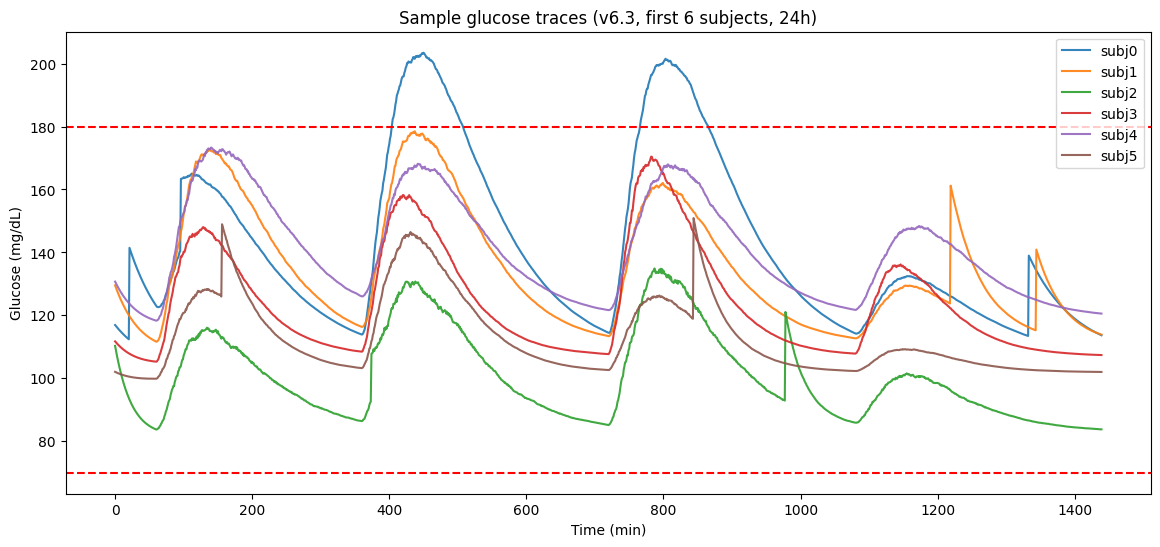

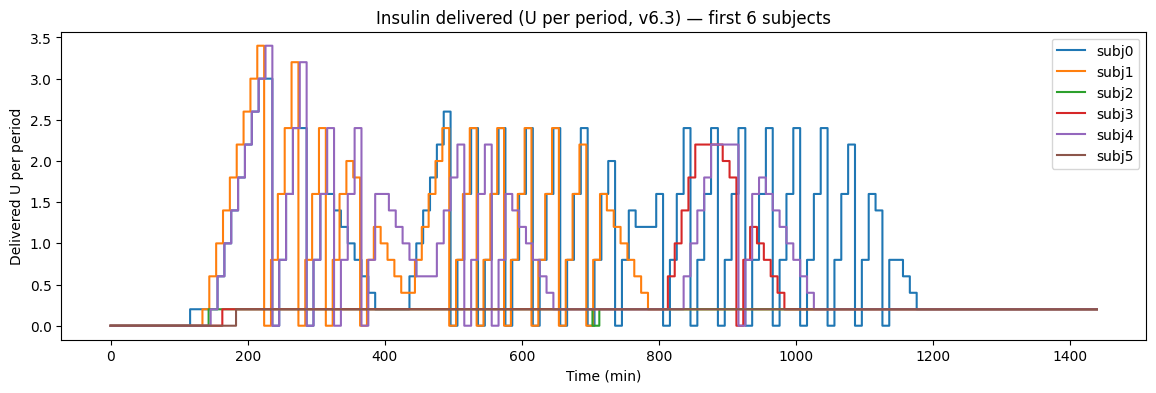

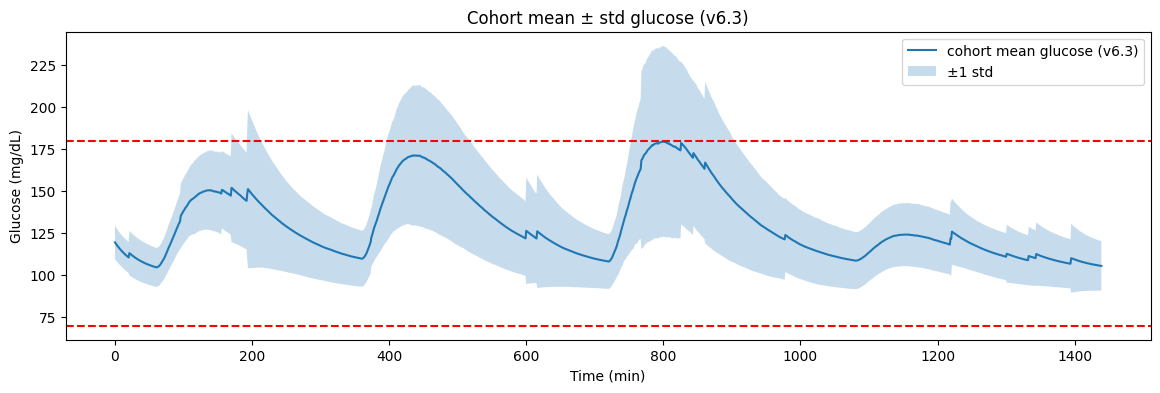


Cohort summary (v6.3):
               count        mean        std         min         25%  \
TIR            10.0   93.034722  12.293739   65.000000   89.375000   
TBR            10.0    0.000000   0.000000    0.000000    0.000000   
TAR            10.0    6.965278  12.293739    0.000000    0.000000   
mean_glucose   10.0  130.119693  24.261886  100.485235  112.302624   
std_glucose    10.0   22.317790  13.143668   11.763670   14.304100   
CV%            10.0   16.458941   6.603863   10.797325   12.007531   

                     50%         75%         max  
TIR           100.000000  100.000000  100.000000  
TBR             0.000000    0.000000    0.000000  
TAR             0.000000   10.625000   35.000000  
mean_glucose  129.208420  141.756681  173.214002  
std_glucose    17.723519   26.081425   56.028666  
CV%            13.818133   18.297785   32.346499  


In [8]:
# Run v6.3 cohort (10 subjects, 24 hours)
df_v6_3, histories_v6_3 = run_cohort_v6_3(n_subjects=10, sim_length_min=1440, seed_base=0)


In [14]:
# ======================================================
# 🎥 v6.3 COHORT VIDEO ANIMATION (6 subjects, 24h)
# ======================================================
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Video

# If histories_v6_3 is already defined, skip running simulation again.
# Otherwise uncomment:
# df_v6_3, histories_v6_3 = run_cohort_v6_3(n_subjects=10, sim_length_min=1440, seed_base=0)

# Choose how many subjects to animate
n_show = min(6, len(histories_v6_3))
histories_to_show = histories_v6_3[:n_show]

# Colors for lines
colors = plt.cm.tab10(np.linspace(0, 1, n_show))

# Find maximum time across subjects
max_len = max(len(h['glucose']) for h in histories_to_show)
tvec = np.arange(max_len)

# Prepare figure
fig, ax = plt.subplots(figsize=(13, 5))
ax.set_xlim(0, max_len)
global_max_glucose = max(np.max(h["glucose"]) for h in histories_to_show)
ax.set_ylim(40, global_max_glucose + 20)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Glucose (mg/dL)")
ax.set_title("Glucose Cohort Animation (v6.3) — First 6 Subjects")

# Standard TIR zone lines
ax.axhline(70, color='red', linestyle='--', linewidth=1)
ax.axhline(180, color='red', linestyle='--', linewidth=1)

# Create line objects
lines = []
for i in range(n_show):
    (line,) = ax.plot([], [], lw=2, color=colors[i], label=f"Subject {i}")
    lines.append(line)

ax.legend(loc="upper right")

# --- Init function ---
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# --- Frame update ---
def update(frame):
    for i, h in enumerate(histories_to_show):
        g = np.array(h['glucose'])
        if frame < len(g):
            # Plot updated trajectory
            lines[i].set_data(tvec[:frame], g[:frame])
    ax.set_title(f"Glucose Cohort Animation (v6.3) — First {n_show} Subjects\nTime = {frame} min")
    return lines

# --- Animation ---
ani = animation.FuncAnimation(
    fig,
    update,
    frames=max_len,
    init_func=init,
    interval=25,   # speed
    blit=False,
    repeat=False,
)

# --- Save as MP4 ---
video_path = "v6_3_cohort_animation.mp4"
ani.save(video_path, writer="ffmpeg", fps=30, dpi=150)
plt.close()

print("✅ Cohort animation saved as:", video_path)
Video(video_path, embed=True)


✅ Cohort animation saved as: v6_3_cohort_animation.mp4


In [10]:
# =============================
# Parameter Summary for v6.3 Cohort
# =============================

def summarize_subject_parameters(histories, num_subjects=5):
    print("Showing parameter summary for first", num_subjects, "subjects:\n")

    for i, hist in enumerate(histories[:num_subjects]):
        print(f"\n--- Subject {i} ---")
        print(f"Initial Glucose: {hist['glucose'][0]:.2f} mg/dL")
        print(f"Mean Glucose: {np.mean(hist['glucose']):.2f} mg/dL")
        print(f"Peak Glucose: {np.max(hist['glucose']):.2f} mg/dL")
        print(f"Min Glucose: {np.min(hist['glucose']):.2f} mg/dL")
        print(f"Total Insulin Delivered: {np.sum(hist.get('delivered_insulin', [0])):.3f} U")
        print(f"Meal Events: {hist.get('meals', 'N/A')}")
        print("---------------------------")

summarize_subject_parameters(histories_v6_3, num_subjects=5)


Showing parameter summary for first 5 subjects:


--- Subject 0 ---
Initial Glucose: 116.93 mg/dL
Mean Glucose: 142.15 mg/dL
Peak Glucose: 203.45 mg/dL
Min Glucose: 112.39 mg/dL
Total Insulin Delivered: 0.000 U
Meal Events: N/A
---------------------------

--- Subject 1 ---
Initial Glucose: 129.53 mg/dL
Mean Glucose: 134.77 mg/dL
Peak Glucose: 178.49 mg/dL
Min Glucose: 111.64 mg/dL
Total Insulin Delivered: 0.000 U
Meal Events: N/A
---------------------------

--- Subject 2 ---
Initial Glucose: 110.30 mg/dL
Mean Glucose: 100.49 mg/dL
Peak Glucose: 134.91 mg/dL
Min Glucose: 83.73 mg/dL
Total Insulin Delivered: 0.000 U
Meal Events: N/A
---------------------------

--- Subject 3 ---
Initial Glucose: 111.73 mg/dL
Mean Glucose: 123.65 mg/dL
Peak Glucose: 170.42 mg/dL
Min Glucose: 105.28 mg/dL
Total Insulin Delivered: 0.000 U
Meal Events: N/A
---------------------------

--- Subject 4 ---
Initial Glucose: 130.72 mg/dL
Mean Glucose: 140.58 mg/dL
Peak Glucose: 173.32 mg/dL
Min Glucose: 118.32 m

In [ ]:
# =============================
# Single Subject Visualizer
# =============================

import matplotlib.pyplot as plt

def plot_single_subject(history, subject_index=0):
    hist = history[subject_index]
    t = np.arange(len(hist['glucose']))

    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # 1. Glucose
    axs[0].plot(t, hist['glucose'], label="True Glucose")
    axs[0].plot(t, hist['measured'], label="Measured (CGM)", alpha=0.4)
    axs[0].axhline(70, color='r', ls='--', alpha=0.7)
    axs[0].axhline(180, color='r', ls='--', alpha=0.7)
    axs[0].set_ylabel("Glucose (mg/dL)")
    axs[0].set_title(f"Subject {subject_index} — Glucose Dynamics")
    axs[0].legend()

    # 2. Insulin Effect (X) + Plasma Insulin
    axs[1].plot(t, hist['X'], label="Insulin Effect X")
    axs[1].plot(t, hist['Ipl'], label="Insulin Plasma (Ipl)")
    axs[1].set_ylabel("Insulin Effect / Plasma Insulin")
    axs[1].set_title("Insulin Dynamics")
    axs[1].legend()

    # 3. Basal Bias (Adaptive Component)
    axs[2].plot(t, hist['basal_bias'], label="Adaptive Basal Bias (AB)")
    axs[2].set_ylabel("Basal Bias")
    axs[2].set_xlabel("Time (min)")
    axs[2].set_title("Adaptive Basal Adjustment")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_single_subject(histories_v6_3, subject_index=0)


In [15]:
# =============================
# Clinical Metrics Summary
# =============================

import pandas as pd

def compute_metrics_for_subject(hist):
    g = np.array(hist['glucose'])

    tir = np.mean((g >= 70) & (g <= 180)) * 100
    tar = np.mean(g > 180) * 100
    tbr = np.mean(g < 70) * 100
    tbr54 = np.mean(g < 54) * 100

    return {
        "Mean": np.mean(g),
        "SD": np.std(g),
        "CV%": (np.std(g) / np.mean(g)) * 100,
        "TIR%": tir,
        "TAR%": tar,
        "TBR%": tbr,
        "TBR < 54%": tbr54,
    }


def cohort_metrics_table(histories):
    records = []
    for i, hist in enumerate(histories):
        rec = compute_metrics_for_subject(hist)
        rec["Subject"] = i
        records.append(rec)

    dfm = pd.DataFrame(records).set_index("Subject")
    return dfm


# Display metrics for entire cohort
metrics_df = cohort_metrics_table(histories_v6_3)
metrics_df


,Mean,SD,CV%,TIR%,TAR%,TBR%,TBR < 54%
Subject,,,,,,,
0,142.149222,26.628990,18.733124,85.833333,14.166667,0.0,0.0
1,134.769367,18.752450,13.914475,100.000000,0.000000,0.0,0.0
2,100.485235,13.788373,13.721790,100.000000,0.000000,0.0,0.0
3,123.647474,16.694588,13.501762,100.000000,0.000000,0.0,0.0
4,140.579061,15.851280,11.275705,100.000000,0.000000,0.0,0.0
5,112.859200,12.185775,10.797325,100.000000,0.000000,0.0,0.0
6,102.208757,11.763670,11.509454,100.000000,0.000000,0.0,0.0
7,112.117099,24.438731,21.797505,100.000000,0.000000,0.0,0.0
8,173.214002,56.028666,32.346499,65.000000,35.000000,0.0,0.0


Running cohort of 200 subjects for 24 hours...
Subject 1/200 done: mean_gl=129.2, TIR=99.2%, TAR=0.8%
Subject 2/200 done: mean_gl=112.6, TIR=100.0%, TAR=0.0%
Subject 3/200 done: mean_gl=126.7, TIR=100.0%, TAR=0.0%
Subject 4/200 done: mean_gl=125.6, TIR=100.0%, TAR=0.0%
Subject 5/200 done: mean_gl=138.3, TIR=88.8%, TAR=11.2%
Subject 6/200 done: mean_gl=114.7, TIR=99.2%, TAR=0.8%
Subject 7/200 done: mean_gl=112.2, TIR=100.0%, TAR=0.0%
Subject 8/200 done: mean_gl=141.4, TIR=90.4%, TAR=9.6%
Subject 9/200 done: mean_gl=101.3, TIR=100.0%, TAR=0.0%
Subject 10/200 done: mean_gl=160.5, TIR=74.1%, TAR=25.9%
Subject 11/200 done: mean_gl=168.1, TIR=66.5%, TAR=33.5%
Subject 12/200 done: mean_gl=99.4, TIR=100.0%, TAR=0.0%
Subject 13/200 done: mean_gl=134.0, TIR=93.4%, TAR=6.6%
Subject 14/200 done: mean_gl=144.0, TIR=75.4%, TAR=24.6%
Subject 15/200 done: mean_gl=126.1, TIR=91.6%, TAR=8.4%
Subject 16/200 done: mean_gl=252.1, TIR=12.6%, TAR=87.4%
Subject 17/200 done: mean_gl=107.8, TIR=100.0%, TAR=0.0%

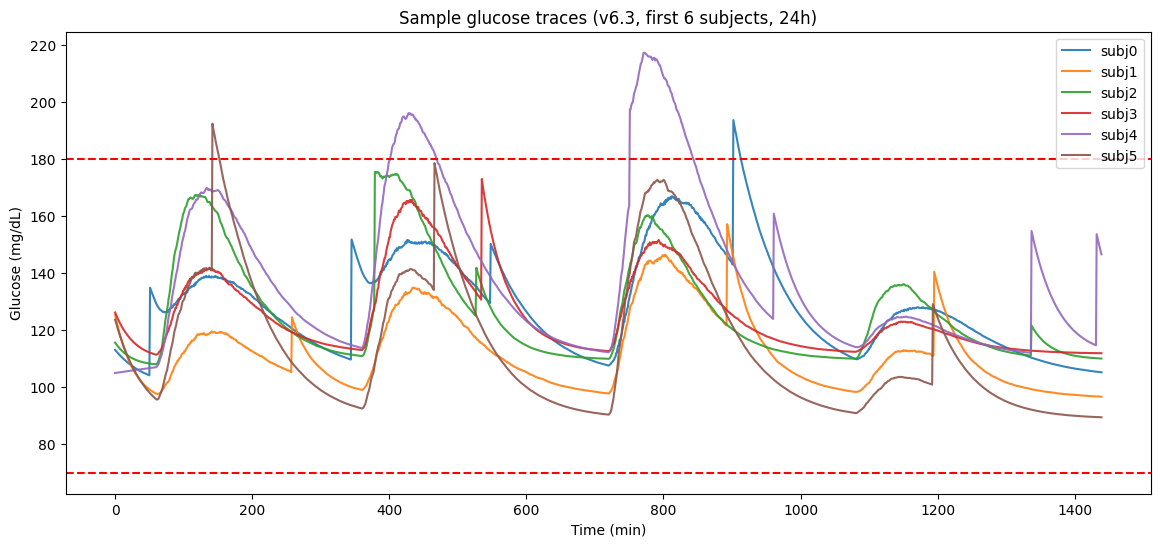

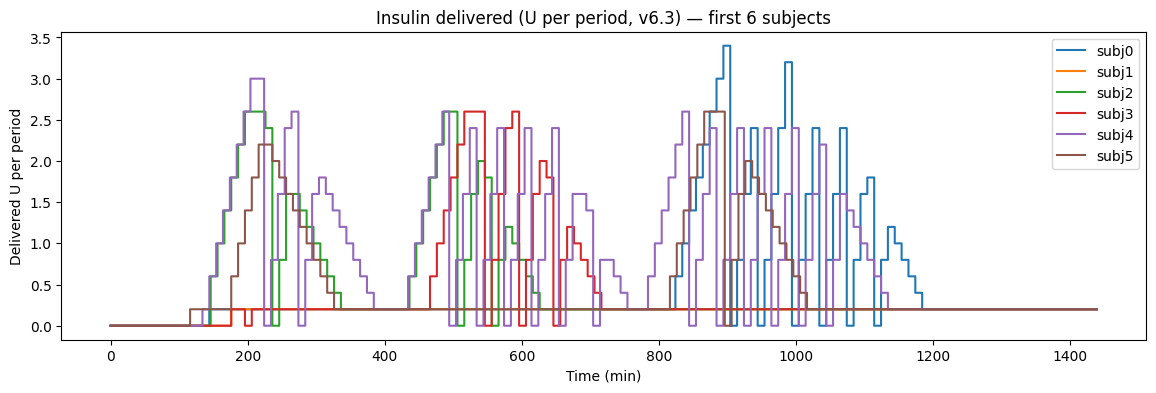

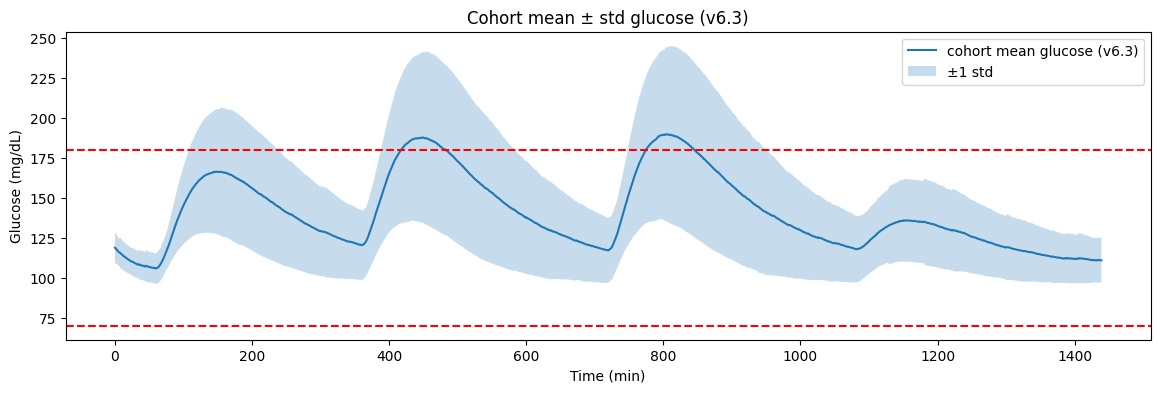


Cohort summary (v6.3):
               count        mean        std        min         25%         50%  \
TIR           200.0   86.298264  19.108157  12.638889   77.638889   96.597222   
TBR           200.0    0.000000   0.000000   0.000000    0.000000    0.000000   
TAR           200.0   13.701736  19.108157   0.000000    0.000000    3.402778   
mean_glucose  200.0  140.542166  28.475114  92.341213  121.246072  134.097113   
std_glucose   200.0   25.915687  14.113271   6.863032   14.986033   22.662899   
CV%           200.0   17.562435   6.297113   6.255138   12.177798   16.984195   

                     75%         max  
TIR           100.000000  100.000000  
TBR             0.000000    0.000000  
TAR            22.361111   87.361111  
mean_glucose  154.034176  254.745597  
std_glucose    32.197900   81.224689  
CV%            21.628794   35.136452  

✅ Completed 200 subjects in 66.20 seconds.

📊 Cohort Summary (first few rows):


,TIR,TBR,TAR,mean_glucose,std_glucose,CV%
subject,,,,,,
0,99.166667,0.0,0.833333,129.220885,17.611919,13.629313
1,100.000000,0.0,0.000000,112.636673,13.307452,11.814493
2,100.000000,0.0,0.000000,126.653759,18.366426,14.501287
3,100.000000,0.0,0.000000,125.620755,14.334875,11.411231
4,88.819444,0.0,11.180556,138.270702,27.824086,20.122908



📈 Aggregate Statistics Across 200 Subjects:


,count,mean,std,min,25%,50%,75%,max
TIR,200.0,86.298264,19.108157,12.638889,77.638889,96.597222,100.000000,100.000000
TBR,200.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TAR,200.0,13.701736,19.108157,0.000000,0.000000,3.402778,22.361111,87.361111
mean_glucose,200.0,140.542166,28.475114,92.341213,121.246072,134.097113,154.034176,254.745597
std_glucose,200.0,25.915687,14.113271,6.863032,14.986033,22.662899,32.197900,81.224689
CV%,200.0,17.562435,6.297113,6.255138,12.177798,16.984195,21.628794,35.136452


In [16]:
# ======================================================
# 🚀 Run Large Cohort: 200 randomized v6.3 subjects
# ======================================================
import time

N_SUBJECTS = 200
SIM_LENGTH_MIN = 1440   # 24 hours
SEED = 2025             # reproducible

print(f"Running cohort of {N_SUBJECTS} subjects for 24 hours...")
start = time.time()

df_200, histories_200 = run_cohort_v6_3(
    n_subjects=N_SUBJECTS,
    sim_length_min=SIM_LENGTH_MIN,
    seed_base=SEED
)

end = time.time()
print(f"\n✅ Completed {N_SUBJECTS} subjects in {end-start:.2f} seconds.")

# Show summary of metrics
print("\n📊 Cohort Summary (first few rows):")
display(df_200.head())

# Overall statistics
print("\n📈 Aggregate Statistics Across 200 Subjects:")
display(df_200.describe().T)


## Future Work: Evaluation on FDA-Approved Virtual Patients

Our current v6.3 engine uses a custom, physiologically-plausible PK/PD model
with randomized virtual subjects.

To align with regulatory-grade evaluation, the next step is to integrate this
controller with an FDA-approved Type 1 Diabetes simulator (e.g., the UVA/Padova
T1DMS), which provides standardized virtual patients used in closed-loop
artificial pancreas studies.
